### Importing Needed packages


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline

In [3]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor

In [4]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

## Reading the data


In [5]:
df = pd.read_csv("HousePrice.csv")

# take a look at the dataset
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


### Types Columns

Columns whose variable type should be changed.


In [6]:
df.dtypes

Area           object
Room            int64
Parking          bool
Warehouse        bool
Elevator         bool
Address        object
Price         float64
Price(USD)    float64
dtype: object

In [7]:
df['Area'] = pd.to_numeric(df['Area'], errors='coerce')

In [8]:
df[['Parking','Warehouse','Elevator']] = df[['Parking','Warehouse','Elevator']].astype(int)


### Data Exploration

Let's first have a descriptive exploration on our data.


In [9]:
# summarize the data
df.describe()

,Area,Room,Parking,Warehouse,Elevator,Price,Price(USD)
count,3473.000000,3479.000000,3479.000000,3479.000000,3479.000000,3.479000e+03,3.479000e+03
mean,106.774547,2.079908,0.847945,0.914631,0.787295,5.359023e+09,1.786341e+05
std,69.365567,0.758275,0.359126,0.279471,0.409279,8.099935e+09,2.699978e+05
min,30.000000,0.000000,0.000000,0.000000,0.000000,3.600000e+06,1.200000e+02
25%,69.000000,2.000000,1.000000,1.000000,1.000000,1.418250e+09,4.727500e+04
50%,90.000000,2.000000,1.000000,1.000000,1.000000,2.900000e+09,9.666667e+04
75%,120.000000,2.000000,1.000000,1.000000,1.000000,6.000000e+09,2.000000e+05
max,929.000000,5.000000,1.000000,1.000000,1.000000,9.240000e+10,3.080000e+06


In [10]:
df.shape

(3479, 8)

### Drop Line

Deleting the lines whose address column is empty or the size of the house is an unrealistic number.


In [11]:
df = df.dropna(subset = ['Address', 'Area'])
df.shape

(3450, 8)

### make columns


Let's create a column number for each unique address.

In [12]:
df['ACode'], unique_addresses = pd.factorize(df['Address'])

<h2>We find the effective columns in the output value</h2>

In [13]:
X = df[['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'ACode']]
y = df['Price(USD)']


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [15]:
model = SGDRegressor(random_state=42)
model.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'Feature': ['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'ACode'],
    'Coefficient': model.coef_
})

print("Feature Importance Table (Linear):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))

Feature Importance Table (Linear):
     Feature    Coefficient
0       Area  167104.187907
1       Room   36071.167961
3  Warehouse   13707.228988
5      ACode   13447.650226
4   Elevator   11581.562375
2    Parking   -3367.695859


In [41]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

ModuleNotFoundError: No module named 'shap'

In [16]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
})
print(feature_importance.sort_values(by='Importance', ascending=False))

     Feature  Importance
0       Area    0.720833
1       Room    0.040817
4   Elevator    0.004238
3  Warehouse    0.002008
5      ACode    0.001643
2    Parking   -0.000544


In [17]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
})
print(feature_importance.sort_values(by='Importance', ascending=False))

     Feature  Importance
0       Area    0.742776
5      ACode    0.152947
1       Room    0.067644
4   Elevator    0.029933
2    Parking    0.004363
3  Warehouse    0.002337


Let's select some features to explore more.


In [18]:
cdf = df[['Area','Room','ACode','Price(USD)']].copy()
cdf.head(9)

,Area,Room,ACode,Price(USD)
0,63.0,1,0,61666.67
1,60.0,1,0,61666.67
2,79.0,2,1,18333.33
3,95.0,2,2,30083.33
4,123.0,2,3,233333.33
5,70.0,2,4,68333.33
6,87.0,2,1,20000.00
7,59.0,1,0,71666.67
8,54.0,2,5,16433.33


<h2 id="multiple_regression_model">Multiple Regression Model</h2>


In [19]:
X = cdf[['Area', 'Room', 'ACode']]
y = cdf['Price(USD)']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit (X_train, Y_train)

print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)

Coefficients:  [ 2377.78494442 50611.7263509    242.9053321 ]
Intercept:  -192035.9010571488


<h2 id="prediction">Prediction</h2>


In [21]:
y_hat= regr.predict(X_test)
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - Y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, Y_test))

Residual sum of squares: 39476629895.33
Variance score: 0.53


<h1>Polynomial</h1>

In [199]:
X = cdf[['Area', 'Room']].values
y = cdf['Price(USD)'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [200]:
poly = PolynomialFeatures(degree=4) 
X_poly = poly.fit_transform(X_train)

model = LinearRegression()
model.fit(X_poly, Y_train)

X_test_poly = poly.transform(X_test)
y_pred = model.predict(X_test_poly)

In [201]:
r2_score = model.score(X_test_poly, Y_test)
print(f'R² Score: {r2_score:.2f}')

R² Score: 0.74


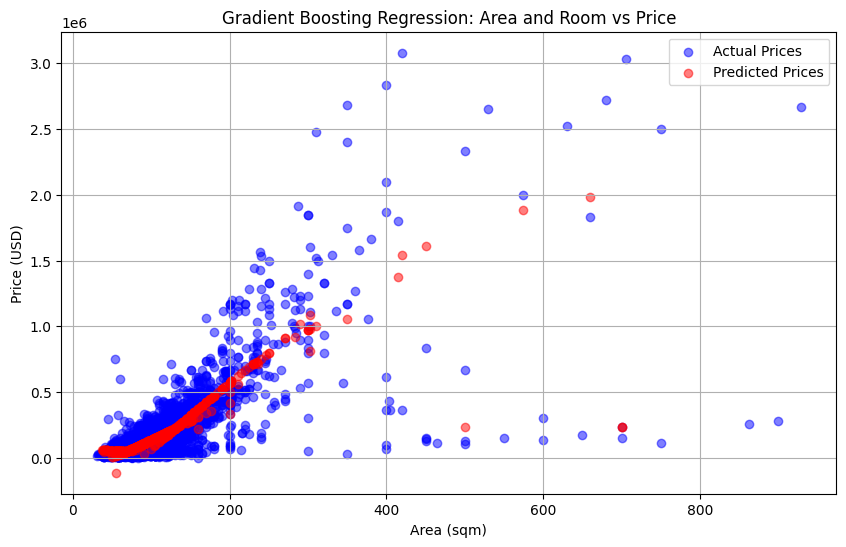

In [202]:
plt.figure(figsize=(10, 6))
plt.scatter(cdf['Area'], cdf['Price(USD)'], color='blue', label='Actual Prices', alpha=0.5)
plt.scatter(X_test[:,0], y_pred, color='red', label='Predicted Prices', alpha=0.5)
plt.title('Gradient Boosting Regression: Area and Room vs Price')
plt.xlabel('Area (sqm)')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()